# Classification with MNIST
We'll be exploring a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. 

Each image is labeled with the digit it represents. 
Since we're trying to predict pictures; and said pictures possess labels, this will naturally fall as a classification problem. 

We will start by fetching the mnist_784 dataset from sklearn. Fortunately there's literally an import for just that, and then we will review the key fields of the dataset.

We will then take a look at it's overall shape.

In [1]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

'data' contains an array with one row per instance and one column per feature
'target' contains an array with labels. 

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

So, we have 70,000 images, with 784 features, as each image is 28 x 28 pixels, and each feature is one pixel's intensity from 0 to 255 (white to black)

In [3]:
y.shape

(70000,)

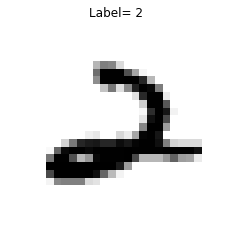

In [119]:
import matplotlib as mpl
import matplotlib.pyplot as plt

i=37763
some_digit = X[i]
some_digit_image = some_digit.reshape(28, 28)

zerosamples=[21,56,5665]
plt.imshow(some_digit_image, cmap="binary")
plt.title("Label= "+str(y[i]))
plt.axis("off")
plt.show()

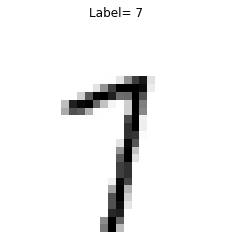

In [116]:
some_digit = X[42]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title("Label= "+str(y[42]))
plt.show()

In [6]:
y[0]

'5'

Most ML algorithims expect numbers, so cast the labels as such. 

In [60]:
import numpy as np
y=y.astype(np.uint8)

Make sure you create a test set and set it aside before inspecting the data. 

In [61]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

For now, let's simplify the problem and try to simply classify the number 5

In [108]:
y_train_5 = (y_train == 5) ## true for all 5s, false for all other digits
y_test_5 = (y_test == 5)

y_train_1 = (y_train == 1) ## true for all 1s, false for all other digits
y_test_1 = (y_test == 1)

y_train_7 = (y_train == 7) ## true for all 7s, false for all other digits
y_test_7 = (y_test == 7)

Now we pick a classifier and train it. Stochastic Gradient Descent (SGD) is one such classifier availiable in Scikit-learn.
It handles large data sets efficiently as it deals with training instances independently. 

In [109]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [110]:
some_digit = X[i]
sgd_clf.predict([some_digit])

array([ True])

In [111]:
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Time to check for the number 5. Is it in this set?

What about the number 1?

In [112]:
some_digit = X[42]
sgd_clf.predict([some_digit])

array([False])

What about the number 7?

In [115]:
sgd_clf.fit(X_train, y_train_7)
some_digit = X[42]
sgd_clf.predict([some_digit])

array([ True])

At a glance, look like our SGD classifier can predict the numbers 5, 1, and 7 without getting mixed up. How to measure this comes next.

# Performance Measures
Evaluating classifiers can be trickier than evaluating regressions seeing as this is unsuprivised learning.
Among the options include:

Cross-Validation

Confusion Matrix

Precision and Recall


## Cross-Validation

While we can utilize Scikit-Learn's cross-validation process, let's implement our own just for kicks and practice.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#here we're doing stratified sampling to keep things representative, doing it n times the amount of splits we want 
skfolds = StratifiedKFold(n_splits=4, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds= X_train[train_index]
    y_train_folds= y_train_5[train_index]
    X_test_fold= X_train[test_index]
    y_test_fold= y_train_5[test_index]
    
    #Time to fit the clone classifier and test how the number '5' will be predicted
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    #now compared the y-predictions with the test fold
    n_correct= sum(y_pred == y_test_fold)
    
    #let's make sure it's presented as a ratio
    print(n_correct / len(y_pred))

C:\Users\David\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9576666666666667
0.9664
0.9651333333333333
0.9536666666666667


### Using SkLearn's Cross Validator

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

Huh. Looks like we have over 95% accuracy, but considering we only need to compliment the probability of "not five" to make these predictions...meh.

Something is off that'll make us want to be more ***precise.*** We'll have to ***recall*** this later.

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

This is why accuracy isn't the best metric for classifiers, especially in dealing with skewed datasets (whereupon some classes are far more likely to occur than others).

## Confusion Matrix

The idea of a confusion matrix is to look at the number of times class A is counted as class B.   For example, how many times was the image of 5 confused for the number 3?

For that, you'd look at the 5th row in the 3rd column of the confusion matrix.

As such, to compute a confusion matrix, a set of *predictions* need to be compared to actual targets. In other words, you'll need to compare a test set to the actuals.

"cross_val_predict" within Sklearn eases that. 

1) From the training set for the number 5 earlier, create a prediction training set via cross_val_predict().
2) Form the confusion matrix via confusion_matrix(training, predictor) to studying the following matrix:

----

true negatives, false positives

false negatives, true positives

--                           --

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Above, each row represents an *actual class*, while each column represents a *predicted* class. 

---

true negatives (53892), false positives (687)

false negatives (1891), true positives (3530)

---

## Precision and Recall

sklearn.metrics contains libraries related to precision and recall. Recall the following formulas:

$precision = \frac{TP}{TP + FP}$


$recall = \frac{TP}{TP + FN}$

In [97]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

What this means is that, adjusting for False Positives, it's only properly identifying the image of 5 about 83% of the time. 

In [98]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

What this means is that, adjusting for False Negatives, it's only properly noting the image of 5 about 65% of the time, believing the rest 35% of the images of fives to not be the number five. 

We can combine the two aspects to create a final __F_Score__. It represents the *harmonic mean* between the two scores. That is, it gives more weight to lower values as opposed to a regular mean calculation.

Due to this, a high F-Score is high only if the precision and recall high.

In [99]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Precision and Recall have an inverse relationship. The more you increase one, the less you have of the other. 

As such, the F1_Score favors metrics with similiar precision and recall.

This may not be what you always want. For example, if you want a classifier that picks videos that are safe-for-children, you likely want more precision and less recall (i.e. risk falsely rejecting a good video and keeping safe videos), lest you have high recall and low precision (i.e. unlikely to falsely mark a good video, but more likely to let bad ones to go through).

Likewise, you might want high recall with a survelliance system. Sure, you'll have more false alarms, but a situation where there actually *was* a thief and the system did nothing about it will be less likely. 

In short, more *precision* means fewer False Positives in exchange of more False Negatives. *This video about China's Geopolitics is bad for children! Strike the account!*

More *recall* means fewer False Negatives in exchange for more False Positives. *This video about China's Geopolitics seems safe enough. This other video about nekkid mods for a video game seems legit too. No need for alarm.*

This is also known as...**The Decision Threshold.**

## Precision/Recall Threshold Trade-off

In [100]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [101]:
threshold= 0

In [102]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([ True])

Setting a threshold variable as we did above and comparing it to the *decision function* enables us to affirm that 
different thresholds yield different results based on whether we're looking for precision or recall.

In the extreme above with a threshold of 0,  the previous code returnes the same result as the predict method.

Below, with an extreme of 8000, we see recall decreases. In other words, it detects actual 5s with a threshold of 0, but misses them when it's 8000.

In [103]:
threshold= 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

Return decision scores with cross_val_predict to help decide what thresholds to use. 

In [104]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [105]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

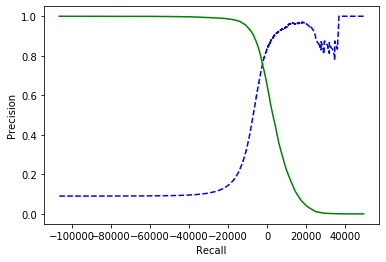

In [107]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    #TODO -add in scale and label code
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [108]:
threshold_90_precision= thresholds[np.argmax(precisions>=0.90)]


In [109]:
y_train_pred_90 = (y_scores>=threshold_90_precision)

# The ROC Curve
The *receiver operating characteristic* curve plots the *true positive rate* (aka recall) against the *false positive rate (FPR)*. It is equal to 1 - the *true negative rate*, also known as *specificity.*

Hence, the ROC curve plots sensitivity verses 1.

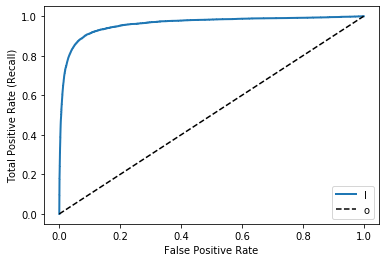

In [110]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') #dashed diagonal
    #todo -- add labels and stuff
    plt.xlabel("False Positive Rate")
    plt.ylabel("Total Positive Rate (Recall)")
    plt.legend("lower right")
    
plot_roc_curve(fpr, tpr, "Random Forest")
plt.show()

In [111]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
    

0.9604938554008616

In [112]:
roc_auc_score(y_train_5, y_scores_forest)

NameError: name 'y_scores_forest' is not defined

Remember, the higher the recall (TPR), the more false positives the classifier produces. The dotted line represents the ROC curve of a purely random classifier, and a good classifier stays as far from that line as possible. 

To choose between TPR and PR curve, use the PR curve whenever the positive class is rare. 


In [ ]:
from sklearn.ensemble import RandomForestClassifier